# Lab 13: Multi-Object Photometry
This lab will demonstrate how to use our photometry tools on an entire image.

Name:

In [1]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import scipy.stats

# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# run the %matplotlib magic command to enable inline plotting
# in the current Notebook
%matplotlib inline

## Load our Image

In [2]:
#Read in our image
hdulist = fits.open('data/aa_aql0007.fits')
hdulist.info()
prihdr = hdulist[0].header
image_data = hdulist[0].data.astype(np.float) #Ensure a good data type
image_data = image_data[0:600,0:600] #Shrink our image

Filename: data/aa_aql0007.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     107   (1024, 1024)   float32   


In [3]:
#Get Useful header info
read_noise = np.float(prihdr['rdnoise'])
gain = np.float(prihdr['gain'])
exptime = np.float(prihdr['exptime'])
image_data = image_data * gain

## Source Detection
The main issue with doing photometry on an entire image is finding all the sources. There are a number of ways to do this, but we will use a standard routine called DAOFIND. DAOFIND runs on images that have had their background removed. We also need to know the standard FWHM of a star in the image.

## FWHM
We need to know what the full-width at Half Maximimum is for a generic star on our image. To do that we can extract a small image around a bright isolated star and then do some basic fitting on it. Let's pick the star located at (503,440).

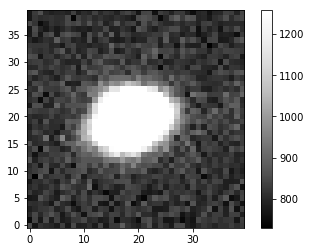

In [4]:
star_data = image_data[420:460,483:523] #Don't forget to reverse x and y
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
(imin,imax) = interval.get_limits(star_data)
plt.imshow(star_data, vmin=imin,vmax=imax)
plt.colorbar()

In [5]:
from photutils import fit_2dgaussian
gfit = fit_2dgaussian(star_data)
ave_sigma = np.mean([gfit.x_stddev.value,gfit.y_stddev.value])
ave_fwhm = ave_sigma * 2.355
print(ave_fwhm)

7.15634937697


## Robust Statistics
We are interested in the mean, median, and standard deviation of the background, but we don't really want the stars to be contributing to this. One way to solve this issue is sigma clipping. In sigma clipping we calculate a median and standard deviation and throw out data points more than some number of sigma away from the median. This process continues for some number of iterations.

In [6]:
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0, iters=5)
print(mean,median,std)

819.790716182 819.515808105 30.9984709739


## DAOfind
Let's run DAOFind on the whole image.

In [7]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=ave_fwhm, threshold=5.*std)    
sources = daofind(image_data - median)
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,546.447162957,14.0198774436,0.303644149887,0.256160058324,-0.431930017683,81.0,0.0,137.379730225,1.82940818705,-0.655776545821
2,108.452264974,21.3739943143,0.411846306984,0.158944759644,-0.269719350018,81.0,0.0,3669.94720459,38.9930744721,-3.97746869797
3,43.0749266569,24.6524272281,0.433216452249,0.0967296620123,-0.228539641436,81.0,0.0,1606.26379395,16.7374792385,-3.05922512829
4,14.8712290969,69.7828197858,0.678604128382,-0.0368288168672,-0.234774388773,81.0,0.0,134.476135254,1.1834624074,-0.182886167877
5,191.441723127,82.9673991544,0.454496686424,0.0884695638083,-0.2738197057,81.0,0.0,4439.44903564,46.9814792776,-4.17981671757
6,101.004815551,85.7435029472,0.414303477747,-0.00294919022039,-0.118371016401,81.0,0.0,316.096252441,3.40926986354,-1.33165344881
7,156.533655129,90.8609439489,0.255607377589,0.209436370037,-0.140968923172,81.0,0.0,451.96005249,5.71836787125,-1.89318022685
8,334.908997982,93.0810659949,0.446489674242,0.148447191076,-0.21514612,81.0,0.0,984.268798828,10.592419614,-2.56248794205
9,274.51883392,110.072687598,0.429895157061,0.105446362625,-0.31244163729,81.0,0.0,439.523986816,4.66075150247,-1.67113987062


## Aperture Photometry
Now we just follow our procedure from Lab 12

In [8]:
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ave_fwhm*2)
bkg_apertures = CircularAnnulus(positions, r_in=ave_fwhm*3., r_out=ave_fwhm*3 + 5.)

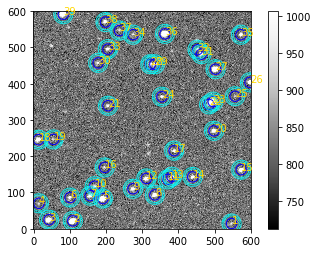

In [9]:
(imin,imax) = interval.get_limits(image_data)
plt.imshow(image_data, vmin=imin,vmax=imax)
plt.colorbar()
apertures.plot(color='blue')
bkg_apertures.plot(color='cyan', hatch='//', alpha=0.8)
#Add some Ids
for i, id in enumerate(sources['id']):
    plt.annotate(id, (sources['xcentroid'][i],sources['ycentroid'][i]),color='gold')
plt.savefig('data/apertures.png',dpi=150) #Save image as a file

In [10]:
fixed_data = image_data
fixed_data[(fixed_data < 0)] = 0
poisson = np.sqrt(fixed_data/gain)
error = np.sqrt(poisson**2 + read_noise**2)

In [11]:
#It turns out that the best measurement of the backgroud for photometry is not the mean, but rather the mode
def getBackground(image_data, apertures):
    bkgs = list()
    for m in apertures.to_mask('center'):
        inc_pix = m.cutout(image_data)[m.cutout(image_data) *m.data >0]
        mode_bak = scipy.stats.mode(inc_pix)
        bkgs.append(float(mode_bak[0]))
    return np.array(bkgs)
def flux2mag(flux,exptime):
    fluxdata = np.array(flux)
    zpt = 25.
    fluxdata[(fluxdata <= 0)] = np.nan
    mag = zpt - 2.5*np.log10(fluxdata) + 2.5*np.log10(exptime)
    return mag

def flux2err(flux_err, flux):
    fluxdata = np.array(flux)
    fluxdata[(fluxdata <= 0)] = np.nan
    merr = 1.0857 *flux_err/fluxdata
    return merr

In [12]:
# measure the aperture sums in both apertures
phot = aperture_photometry(image_data, apertures,error=error)
bkg_mode = getBackground(image_data,bkg_apertures)
bkg_sum = bkg_mode * apertures.area()
phot['bkg_sum'] = bkg_sum
flux_bkgsub = phot['aperture_sum'] - bkg_sum
phot['aperture_sum_bkgsub'] = flux_bkgsub
mag = flux2mag(phot['aperture_sum_bkgsub'],exptime)
merr = flux2err(phot['aperture_sum_err'],phot['aperture_sum_bkgsub'])
phot['Mag'] = mag
phot['Mag_err'] = merr
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,bkg_sum,aperture_sum_bkgsub,Mag,Mag_err
,pix,pix,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,546.4471629569749,14.019877443646932,537652.734955,633.804795438,475945.31271,61707.4222452,17.4695346143,0.0111513630187
2,108.45226497428216,21.373994314318917,770212.169736,746.155574869,477411.424186,292800.745551,15.7789476804,0.00276673171071
3,43.07492665685516,24.652427228116697,625869.230002,678.615882085,458208.97566,167660.254341,16.3843028243,0.00439444199863
4,14.871229096936771,69.7828197857918,534308.117957,632.043332418,450892.38237,83415.7355868,17.1422581662,0.00822637888618
5,191.44172312724092,82.96739915439129,787973.476421,754.048415575,516390.881621,271582.5948,15.8606232924,0.00301444341598
6,101.00481555103674,85.74350294718674,546550.571426,638.467234634,521566.668161,24983.9032645,18.4512274018,0.0277452193639
7,156.53365512910298,90.86094394885357,560809.047275,645.868454305,535934.006775,24875.0404999,18.4559686347,0.0281896779562
8,334.908997981809,93.0810659948613,584682.464286,658.074214361,453823.367997,130859.096289,16.6533683341,0.00545985105196


## Look at your data
Due to crowding or being near the edge of the image, some stars are probably not useful. Look at your apertures.png file to see which stars are likely not to be good.

## Save your data
The last step is to save your data, so that you can use it later. All of the non-image data we work with are astropy tables. You can use the `write()` method to write your data out.

In [13]:
phot.write('data/phot.csv',overwrite=True)